In [1]:
# A Technical Implementation of MV-Swin-T for Multi-View Mammogram Classification
# ==============================================================================
# This notebook provides a complete, end-to-end implementation of the
# MV-Swin-T architecture, translating the concepts from the research paper
# into a functional PyTorch model.

# ==============================================================================
# 1. Environment Setup and Data Preparation
# ==============================================================================

# 1.1. Imports and Configuration
import os
import re
import glob
import pandas as pd
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# --- Configuration ---
class Config:
    CSV_PATH = r"C:\Users\Shantanu\OneDrive\Desktop\Sem 7\Capstone Project\data\cbis_ddsm\csv"
    IMAGE_PATH = r"C:\Users\Shantanu\OneDrive\Desktop\Sem 7\Capstone Project\data\cbis_ddsm\jpeg"

    # Model Hyperparameters
    IMG_SIZE = 384
    BATCH_SIZE = 4
    EPOCHS = 100 # Reduced for demonstration; paper uses 100
    LEARNING_RATE = 0.0001
    WEIGHT_DECAY = 0.001

    # Swin Transformer specific (Swin-T configuration)
    EMBED_DIM = 96
    DEPTHS = [2, 2, 6, 2]
    NUM_HEADS = [3, 6, 12, 24] # Corrected: Filled in standard Swin-T heads
    WINDOW_SIZE = 12

    # Training settings
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    SEED = 42
    NUM_WORKERS = 0
    PIN_MEMORY = True
    EARLY_STOPPING_PATIENCE = 10


config = Config()

# --- Reproducibility ---
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(config.SEED)
print(f"Using device: {config.DEVICE}")

Using device: cuda


In [2]:
# ==============================================================================
# 1.2. FINAL CORRECTED: Data Loading and Path Mapping
# ==============================================================================
# The debug output revealed the CSV paths contain TWO UID-like strings.
# This final version correctly extracts the SECOND (and last) one, which
# corresponds to the actual folder containing the JPEG images.

# Load metadata CSVs
mass_df = pd.read_csv(os.path.join(config.CSV_PATH, 'mass_case_description_train_set.csv'))
calc_df = pd.read_csv(os.path.join(config.CSV_PATH, 'calc_case_description_train_set.csv'))
full_df = pd.concat([mass_df, calc_df], ignore_index=True)

# Create simplified patient ID and a unique ID for each breast
def extract_simple_patient_id(pid):
    parts = pid.split('_')
    for i, part in enumerate(parts):
        if part == 'P':
            return f"{part}_{parts[i+1]}"
    return pid

full_df['simple_patient_id'] = full_df['patient_id'].apply(extract_simple_patient_id)
full_df['patient_breast_id'] = full_df['simple_patient_id'] + '_' + full_df['left or right breast']
full_df['label'] = full_df['pathology'].apply(lambda x: 1 if 'MALIGNANT' in x.upper() else 0)

# --- Function to map CSV paths to actual JPEG paths on disk ---
def find_jpeg_path(csv_path_series):
    jpeg_paths = []
    for csv_path in tqdm(csv_path_series, desc="Mapping CSV to JPEG paths"):
        # *** FIX: Find all UID-like parts and take the LAST one. ***
        uid_parts = [part for part in csv_path.split('/') if part.startswith('1.3.6.')]

        if uid_parts:
            # The correct folder is the last UID in the path string
            dicom_uid_folder = uid_parts[-1]
            search_pattern = os.path.join(config.IMAGE_PATH, dicom_uid_folder, '*.jpg')
            found_files = glob.glob(search_pattern)
            jpeg_paths.append(found_files[0] if found_files else None)
        else:
            jpeg_paths.append(None)

    return jpeg_paths

# Apply the mapping function
full_df['jpeg_path'] = find_jpeg_path(full_df['image file path'])

# Remove rows where no corresponding JPEG file was found
original_rows = len(full_df)
full_df.dropna(subset=['jpeg_path'], inplace=True)
print(f"\nSuccessfully mapped {len(full_df)} of {original_rows} CSV entries to JPEG files.")

# --- Ipsilateral View Pairing Algorithm ---
paired_data = []
grouped = full_df.groupby('patient_breast_id')

for name, group in tqdm(grouped, desc="Pairing CC and MLO views"):
    cc_view = group[group['image view'] == 'CC']
    mlo_view = group[group['image view'] == 'MLO']

    if not cc_view.empty and not mlo_view.empty:
        for _, cc_row in cc_view.iterrows():
            for _, mlo_row in mlo_view.iterrows():
                paired_data.append({
                    'patient_breast_id': name,
                    'cc_path': cc_row['jpeg_path'],
                    'mlo_path': mlo_row['jpeg_path'],
                    'label': cc_row['label']
                })

paired_df = pd.DataFrame(paired_data)
print(f"\nSuccessfully created {len(paired_df)} CC/MLO pairs.")
print("\nSample of Paired DataFrame:")
print(paired_df.head())

Mapping CSV to JPEG paths: 100%|██████████| 2864/2864 [00:00<00:00, 6577.87it/s]



Successfully mapped 2864 of 2864 CSV entries to JPEG files.


Pairing CC and MLO views: 100%|██████████| 1358/1358 [00:00<00:00, 1528.83it/s]


Successfully created 1956 CC/MLO pairs.

Sample of Paired DataFrame:
  patient_breast_id                                            cc_path  \
0      P_00001_LEFT  C:\Users\Shantanu\OneDrive\Desktop\Sem 7\Capst...   
1      P_00004_LEFT  C:\Users\Shantanu\OneDrive\Desktop\Sem 7\Capst...   
2     P_00005_RIGHT  C:\Users\Shantanu\OneDrive\Desktop\Sem 7\Capst...   
3      P_00007_LEFT  C:\Users\Shantanu\OneDrive\Desktop\Sem 7\Capst...   
4      P_00008_LEFT  C:\Users\Shantanu\OneDrive\Desktop\Sem 7\Capst...   

                                            mlo_path  label  
0  C:\Users\Shantanu\OneDrive\Desktop\Sem 7\Capst...      1  
1  C:\Users\Shantanu\OneDrive\Desktop\Sem 7\Capst...      0  
2  C:\Users\Shantanu\OneDrive\Desktop\Sem 7\Capst...      1  
3  C:\Users\Shantanu\OneDrive\Desktop\Sem 7\Capst...      0  
4  C:\Users\Shantanu\OneDrive\Desktop\Sem 7\Capst...      0  


In [3]:
# ==============================================================================
# 2. CBIS-DDSM Multi-View Dataloader
# ==============================================================================

# 2.1. Custom PyTorch Dataset
class CBISDDSMDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load images from actual paths
        cc_image = cv2.imread(row['cc_path'], cv2.IMREAD_GRAYSCALE)
        mlo_image = cv2.imread(row['mlo_path'], cv2.IMREAD_GRAYSCALE)
        
        # --- Preprocessing and Enhancement ---
        # Convert to 3 channels for standard models
        cc_image = cv2.cvtColor(cc_image, cv2.COLOR_GRAY2RGB)
        mlo_image = cv2.cvtColor(mlo_image, cv2.COLOR_GRAY2RGB)

        # Apply CLAHE for contrast enhancement on each channel
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        for i in range(3):
            cc_image[:, :, i] = clahe.apply(cc_image[:, :, i])
            mlo_image[:, :, i] = clahe.apply(mlo_image[:, :, i])

        label = torch.tensor(row['label'], dtype=torch.float32)

        if self.transform:
            cc_augmented = self.transform(image=cc_image)['image']
            mlo_augmented = self.transform(image=mlo_image)['image']

        return {
            'cc_view': cc_augmented,
            'mlo_view': mlo_augmented,
            'label': label.unsqueeze(0)
        }

# 2.2. Data Augmentations
# Define augmentations as specified in the paper (flips, rotation)
train_transform = A.Compose([
    A.Resize(config.IMG_SIZE, config.IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(config.IMG_SIZE, config.IMG_SIZE),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2(),
])

In [4]:
# 2.3. DataLoaders Instantiation
train_df, val_df = train_test_split(paired_df, test_size=0.2, random_state=config.SEED, stratify=paired_df['label'])

train_dataset = CBISDDSMDataset(train_df, transform=train_transform)
val_dataset = CBISDDSMDataset(val_df, transform=val_transform)

train_loader = DataLoader(
    train_dataset, batch_size=config.BATCH_SIZE, shuffle=True,
    num_workers=config.NUM_WORKERS, pin_memory=config.PIN_MEMORY
)
val_loader = DataLoader(
    val_dataset, batch_size=config.BATCH_SIZE, shuffle=False,
    num_workers=config.NUM_WORKERS, pin_memory=config.PIN_MEMORY
)

print(f"\nTrain loader batches: {len(train_loader)}")
print(f"Validation loader batches: {len(val_loader)}")


Train loader batches: 391
Validation loader batches: 98


In [5]:
# ==============================================================================
# 3. Core Architectural Components of MV-Swin-T (Cleaned Version)
# ==============================================================================

# --- 3.1. Shared Utilities ---
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        return self.drop(self.fc2(self.drop(self.act(self.fc1(x)))))

def window_partition(x, window_size):
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    return x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size * window_size, C)

def window_reverse(windows, window_size, H, W):
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    return x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)

class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96):
        super().__init__()
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return self.norm(x)

class PatchMerging(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = nn.LayerNorm(4 * dim)

    def forward(self, x, H, W):
        B, L, C = x.shape
        x = x.view(B, H, W, C)
        x = torch.cat([
            x[:, 0::2, 0::2, :], x[:, 1::2, 0::2, :],
            x[:, 0::2, 1::2, :], x[:, 1::2, 1::2, :]
        ], -1)
        x = x.view(B, -1, 4 * C)
        x = self.norm(x)
        return self.reduction(x)


In [6]:
# --- 3.2. Multi-Head Dynamic Attention (MDA) ---
class MultiHeadDynamicAttention(nn.Module):
    def __init__(self, dim, num_heads, window_size):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.q = nn.Linear(dim, dim)
        self.k = nn.Linear(dim, dim)
        self.v = nn.Linear(dim, dim)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x_origin, x_cross):
        B_, N, C = x_origin.shape
        q = self.q(x_origin).reshape(B_, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        k = self.k(x_cross).reshape(B_, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        v = self.v(x_origin).reshape(B_, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        return self.proj(x)


In [7]:
# --- 3.3. Omni-Attention Transformer Block ---
class OmniAttentionTransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, window_size, shift_size=0, mlp_ratio=4.):
        super().__init__()
        self.window_size = window_size
        self.shift_size = shift_size
        
        self.norm1_cc = nn.LayerNorm(dim)
        self.norm1_mlo = nn.LayerNorm(dim)
        self.attn = MultiHeadDynamicAttention(dim, num_heads, window_size)
        
        self.norm2_cc = nn.LayerNorm(dim)
        self.norm2_mlo = nn.LayerNorm(dim)
        self.mlp_cc = Mlp(dim, int(dim * mlp_ratio), act_layer=nn.ReLU)
        self.mlp_mlo = Mlp(dim, int(dim * mlp_ratio), act_layer=nn.ReLU)

    def forward(self, x_cc, x_mlo, H, W):
        B, L, C = x_cc.shape
        shortcut_cc, shortcut_mlo = x_cc, x_mlo
        
        x_cc, x_mlo = self.norm1_cc(x_cc).view(B, H, W, C), self.norm1_mlo(x_mlo).view(B, H, W, C)

        if self.shift_size > 0:
            shifted_x_cc = torch.roll(x_cc, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
            shifted_x_mlo = torch.roll(x_mlo, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x_cc, shifted_x_mlo = x_cc, x_mlo

        x_windows_cc = window_partition(shifted_x_cc, self.window_size)
        x_windows_mlo = window_partition(shifted_x_mlo, self.window_size)
        
        attn_windows_cc = self.attn(x_windows_cc, x_windows_mlo)
        attn_windows_mlo = self.attn(x_windows_mlo, x_windows_cc)

        shifted_x_cc = window_reverse(attn_windows_cc, self.window_size, H, W)
        shifted_x_mlo = window_reverse(attn_windows_mlo, self.window_size, H, W)

        if self.shift_size > 0:
            x_cc = torch.roll(shifted_x_cc, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
            x_mlo = torch.roll(shifted_x_mlo, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x_cc, x_mlo = shifted_x_cc, shifted_x_mlo
            
        x_cc, x_mlo = x_cc.view(B, L, C), x_mlo.view(B, L, C)
        x_cc = shortcut_cc + x_cc
        x_mlo = shortcut_mlo + x_mlo
        
        x_cc = x_cc + self.mlp_cc(self.norm2_cc(x_cc))
        x_mlo = x_mlo + self.mlp_mlo(self.norm2_mlo(x_mlo))
        return x_cc, x_mlo


In [8]:
# --- 3.4. Standard Swin Transformer Block (for shared stages) ---
class WindowAttention(nn.Module):
    def __init__(self, dim, num_heads, window_size):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        return self.proj(x)

class StandardSwinBlock(nn.Module):
    def __init__(self, dim, num_heads, window_size, shift_size=0, mlp_ratio=4.):
        super().__init__()
        self.window_size = window_size
        self.shift_size = shift_size
        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention(dim, num_heads, window_size)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = Mlp(dim, int(dim * mlp_ratio))

    def forward(self, x, H, W):
        B, L, C = x.shape
        shortcut = x
        x = self.norm1(x).view(B, H, W, C)
        
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x
            
        x_windows = window_partition(shifted_x, self.window_size)
        attn_windows = self.attn(x_windows)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)

        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        
        x = x.view(B, L, C)
        x = shortcut + x
        x = x + self.mlp(self.norm2(x))
        return x


In [9]:
# --- 3.5. Full MV-Swin-T Model ---
class MVSwinT(nn.Module):
    def __init__(self, img_size=384, patch_size=4, in_chans=3, num_classes=1,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=12, mlp_ratio=4., norm_layer=nn.LayerNorm):
        super().__init__()
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.patches_resolution = [img_size // patch_size, img_size // patch_size]
        
        self.patch_embed_cc = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        self.patch_embed_mlo = PatchEmbed(img_size, patch_size, in_chans, embed_dim)

        # Stage 1 & 2 (Omni-Attention)
        self.stage1 = self.build_stage(embed_dim, depths[0], num_heads[0], window_size, mlp_ratio, is_omni=True)
        self.patch_merge1_cc, self.patch_merge1_mlo = PatchMerging(embed_dim), PatchMerging(embed_dim)
        self.stage2 = self.build_stage(embed_dim*2, depths[1], num_heads[1], window_size, mlp_ratio, is_omni=True)

        # Fusion
        self.fusion_norm = norm_layer(embed_dim * 4)
        self.fusion_linear = nn.Linear(embed_dim * 4, embed_dim * 2)

        # Stage 3 & 4 (Shared Swin)
        self.patch_merge2 = PatchMerging(embed_dim * 2)
        self.stage3 = self.build_stage(embed_dim*4, depths[2], num_heads[2], window_size, mlp_ratio, is_omni=False)
        self.patch_merge3 = PatchMerging(embed_dim * 4)
        self.stage4 = self.build_stage(embed_dim*8, depths[3], num_heads[3], window_size, mlp_ratio, is_omni=False)

        # Classifier head
        self.norm = norm_layer(embed_dim * 8)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(embed_dim * 8, num_classes)

    def build_stage(self, dim, depth, num_heads, window_size, mlp_ratio, is_omni):
        block_class = OmniAttentionTransformerBlock if is_omni else StandardSwinBlock
        return nn.ModuleList([
            block_class(dim, num_heads, window_size, shift_size=(0 if i % 2 == 0 else window_size // 2), mlp_ratio=mlp_ratio)
            for i in range(depth)
        ])

    def forward(self, x_cc, x_mlo):
        x_cc, x_mlo = self.patch_embed_cc(x_cc), self.patch_embed_mlo(x_mlo)
        H, W = self.patches_resolution

        # Stage 1
        for blk in self.stage1:
            x_cc, x_mlo = blk(x_cc, x_mlo, H, W)
        x_cc, x_mlo = self.patch_merge1_cc(x_cc, H, W), self.patch_merge1_mlo(x_mlo, H, W)
        H, W = H//2, W//2

        # Stage 2
        for blk in self.stage2:
            x_cc, x_mlo = blk(x_cc, x_mlo, H, W)

        # Fusion
        x = torch.cat([x_cc, x_mlo], dim=2)
        x = self.fusion_linear(self.fusion_norm(x))

        # Stage 3
        x = self.patch_merge2(x, H, W)
        H, W = H//2, W//2
        for blk in self.stage3:
            x = blk(x, H, W)

        # Stage 4
        x = self.patch_merge3(x, H, W)
        H, W = H//2, W//2
        for blk in self.stage4:
            x = blk(x, H, W)

        # Classification
        x = self.norm(x)
        x = self.avgpool(x.transpose(1, 2))
        return self.head(torch.flatten(x, 1))


In [10]:
# ==============================================================================
# 4. Training Configuration and Execution
# ==============================================================================

# 4.1. Instantiating the Model and Utilities
model = MVSwinT(
    img_size=config.IMG_SIZE, embed_dim=config.EMBED_DIM,
    depths=config.DEPTHS, num_heads=config.NUM_HEADS, window_size=config.WINDOW_SIZE
).to(config.DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
loss_fn = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

print(f"\nModel has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters.")


Model has 28,393,345 trainable parameters.


In [11]:
# 4.2. Training and Validation Functions
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in tqdm(loader, desc="Training"):
        cc_view, mlo_view, labels = batch['cc_view'].to(device), batch['mlo_view'].to(device), batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(cc_view, mlo_view)
        loss = loss_fn(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        all_preds.append(torch.sigmoid(outputs).detach().cpu())
        all_labels.append(labels.cpu())

    preds = torch.cat(all_preds).numpy()
    labels = torch.cat(all_labels).numpy()
    return total_loss / len(loader), roc_auc_score(labels, preds)

def validate(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Validating"):
            cc_view, mlo_view, labels = batch['cc_view'].to(device), batch['mlo_view'].to(device), batch['label'].to(device)
            outputs = model(cc_view, mlo_view)
            total_loss += loss_fn(outputs, labels).item()
            all_preds.append(torch.sigmoid(outputs).cpu())
            all_labels.append(labels.cpu())

    preds = torch.cat(all_preds).numpy()
    labels = torch.cat(all_labels).numpy()
    return total_loss / len(loader), roc_auc_score(labels, preds)


In [12]:
# 4.3. The Main Training Loop
history = {'train_loss': [], 'val_loss': [], 'train_auc': [], 'val_auc': []}
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(config.EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{config.EPOCHS} ---")
    
    train_loss, train_auc = train_one_epoch(model, train_loader, optimizer, loss_fn, config.DEVICE)
    val_loss, val_auc = validate(model, val_loader, loss_fn, config.DEVICE)
    
    print(f"Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_auc'].append(train_auc)
    history['val_auc'].append(val_auc)
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'mv_swin_t_best_model.pth')
        print("Validation loss improved. Model saved.")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"Validation loss did not improve. Patience: {patience_counter}/{config.EARLY_STOPPING_PATIENCE}")

    if patience_counter >= config.EARLY_STOPPING_PATIENCE:
        print("Early stopping triggered.")
        break



--- Epoch 1/100 ---


Validating: 100%|██████████| 98/98 [02:16<00:00,  1.39s/it]


Train Loss: 0.6827, Train AUC: 0.4845
Val Loss: 0.6299, Val AUC: 0.6481
Validation loss improved. Model saved.

--- Epoch 2/100 ---


Validating: 100%|██████████| 98/98 [02:17<00:00,  1.40s/it]


Train Loss: 0.6376, Train AUC: 0.5368
Val Loss: 0.6380, Val AUC: 0.6222
Validation loss did not improve. Patience: 1/10

--- Epoch 3/100 ---


Validating: 100%|██████████| 98/98 [02:16<00:00,  1.40s/it]


Train Loss: 0.6305, Train AUC: 0.5489
Val Loss: 0.5992, Val AUC: 0.6665
Validation loss improved. Model saved.

--- Epoch 4/100 ---


Validating: 100%|██████████| 98/98 [02:18<00:00,  1.41s/it]


Train Loss: 0.6316, Train AUC: 0.5489
Val Loss: 0.5989, Val AUC: 0.6618
Validation loss improved. Model saved.

--- Epoch 5/100 ---


Validating: 100%|██████████| 98/98 [02:17<00:00,  1.40s/it]


Train Loss: 0.6212, Train AUC: 0.5743
Val Loss: 0.6026, Val AUC: 0.6706
Validation loss did not improve. Patience: 1/10

--- Epoch 6/100 ---


Validating: 100%|██████████| 98/98 [02:17<00:00,  1.40s/it]


Train Loss: 0.6254, Train AUC: 0.5695
Val Loss: 0.6030, Val AUC: 0.6569
Validation loss did not improve. Patience: 2/10

--- Epoch 7/100 ---


Validating: 100%|██████████| 98/98 [02:17<00:00,  1.40s/it]


Train Loss: 0.6264, Train AUC: 0.5801
Val Loss: 0.6109, Val AUC: 0.6356
Validation loss did not improve. Patience: 3/10

--- Epoch 8/100 ---


Validating: 100%|██████████| 98/98 [02:18<00:00,  1.41s/it]


Train Loss: 0.6208, Train AUC: 0.5868
Val Loss: 0.6130, Val AUC: 0.6420
Validation loss did not improve. Patience: 4/10

--- Epoch 9/100 ---


Validating: 100%|██████████| 98/98 [02:18<00:00,  1.42s/it]


Train Loss: 0.6203, Train AUC: 0.5924
Val Loss: 0.6129, Val AUC: 0.6449
Validation loss did not improve. Patience: 5/10

--- Epoch 10/100 ---


Validating: 100%|██████████| 98/98 [02:21<00:00,  1.44s/it]


Train Loss: 0.6221, Train AUC: 0.5871
Val Loss: 0.6396, Val AUC: 0.6523
Validation loss did not improve. Patience: 6/10

--- Epoch 11/100 ---


Validating: 100%|██████████| 98/98 [02:20<00:00,  1.44s/it]


Train Loss: 0.6194, Train AUC: 0.6052
Val Loss: 0.6031, Val AUC: 0.6618
Validation loss did not improve. Patience: 7/10

--- Epoch 12/100 ---


Validating: 100%|██████████| 98/98 [02:19<00:00,  1.42s/it]


Train Loss: 0.6120, Train AUC: 0.6255
Val Loss: 0.6009, Val AUC: 0.6585
Validation loss did not improve. Patience: 8/10

--- Epoch 13/100 ---


Validating: 100%|██████████| 98/98 [02:18<00:00,  1.42s/it]


Train Loss: 0.6118, Train AUC: 0.6231
Val Loss: 0.6010, Val AUC: 0.6580
Validation loss did not improve. Patience: 9/10

--- Epoch 14/100 ---


Validating: 100%|██████████| 98/98 [02:18<00:00,  1.41s/it]


Train Loss: 0.6127, Train AUC: 0.6180
Val Loss: 0.5987, Val AUC: 0.6650
Validation loss improved. Model saved.

--- Epoch 15/100 ---


Validating: 100%|██████████| 98/98 [02:18<00:00,  1.41s/it]


Train Loss: 0.6123, Train AUC: 0.6209
Val Loss: 0.5998, Val AUC: 0.6656
Validation loss did not improve. Patience: 1/10

--- Epoch 16/100 ---


Validating: 100%|██████████| 98/98 [02:18<00:00,  1.41s/it]


Train Loss: 0.6091, Train AUC: 0.6272
Val Loss: 0.6089, Val AUC: 0.6623
Validation loss did not improve. Patience: 2/10

--- Epoch 17/100 ---


Validating: 100%|██████████| 98/98 [02:18<00:00,  1.41s/it]


Train Loss: 0.6109, Train AUC: 0.6145
Val Loss: 0.5949, Val AUC: 0.6444
Validation loss improved. Model saved.

--- Epoch 18/100 ---


Validating: 100%|██████████| 98/98 [02:18<00:00,  1.41s/it]


Train Loss: 0.6060, Train AUC: 0.6205
Val Loss: 0.5834, Val AUC: 0.6438
Validation loss improved. Model saved.

--- Epoch 19/100 ---


Validating: 100%|██████████| 98/98 [02:17<00:00,  1.41s/it]


Train Loss: 0.5960, Train AUC: 0.6305
Val Loss: 0.5783, Val AUC: 0.6504
Validation loss improved. Model saved.

--- Epoch 20/100 ---


Validating: 100%|██████████| 98/98 [02:18<00:00,  1.41s/it]


Train Loss: 0.5970, Train AUC: 0.6286
Val Loss: 0.5839, Val AUC: 0.6615
Validation loss did not improve. Patience: 1/10

--- Epoch 21/100 ---


Validating: 100%|██████████| 98/98 [02:18<00:00,  1.42s/it]


Train Loss: 0.5916, Train AUC: 0.6464
Val Loss: 0.5790, Val AUC: 0.6778
Validation loss did not improve. Patience: 2/10

--- Epoch 22/100 ---


Validating: 100%|██████████| 98/98 [02:19<00:00,  1.42s/it]


Train Loss: 0.5898, Train AUC: 0.6473
Val Loss: 0.5748, Val AUC: 0.6674
Validation loss improved. Model saved.

--- Epoch 23/100 ---


Validating: 100%|██████████| 98/98 [02:21<00:00,  1.44s/it]


Train Loss: 0.5897, Train AUC: 0.6541
Val Loss: 0.5817, Val AUC: 0.6849
Validation loss did not improve. Patience: 1/10

--- Epoch 24/100 ---


Validating: 100%|██████████| 98/98 [02:17<00:00,  1.41s/it]


Train Loss: 0.5929, Train AUC: 0.6367
Val Loss: 0.5745, Val AUC: 0.6866
Validation loss improved. Model saved.

--- Epoch 25/100 ---


Validating: 100%|██████████| 98/98 [02:18<00:00,  1.41s/it]


Train Loss: 0.5859, Train AUC: 0.6629
Val Loss: 0.5755, Val AUC: 0.7012
Validation loss did not improve. Patience: 1/10

--- Epoch 26/100 ---


Validating: 100%|██████████| 98/98 [02:16<00:00,  1.40s/it]


Train Loss: 0.5850, Train AUC: 0.6675
Val Loss: 0.5794, Val AUC: 0.6977
Validation loss did not improve. Patience: 2/10

--- Epoch 27/100 ---


Validating: 100%|██████████| 98/98 [02:16<00:00,  1.40s/it]


Train Loss: 0.5883, Train AUC: 0.6619
Val Loss: 0.5771, Val AUC: 0.6943
Validation loss did not improve. Patience: 3/10

--- Epoch 28/100 ---


Validating: 100%|██████████| 98/98 [02:16<00:00,  1.40s/it]


Train Loss: 0.5832, Train AUC: 0.6742
Val Loss: 0.5707, Val AUC: 0.6994
Validation loss improved. Model saved.

--- Epoch 29/100 ---


Validating: 100%|██████████| 98/98 [02:18<00:00,  1.41s/it]


Train Loss: 0.5795, Train AUC: 0.6862
Val Loss: 0.5668, Val AUC: 0.7046
Validation loss improved. Model saved.

--- Epoch 30/100 ---


Validating: 100%|██████████| 98/98 [02:18<00:00,  1.41s/it]


Train Loss: 0.5789, Train AUC: 0.6886
Val Loss: 0.5855, Val AUC: 0.7064
Validation loss did not improve. Patience: 1/10

--- Epoch 31/100 ---


Validating: 100%|██████████| 98/98 [02:13<00:00,  1.36s/it]


Train Loss: 0.5790, Train AUC: 0.6893
Val Loss: 0.5617, Val AUC: 0.7238
Validation loss improved. Model saved.

--- Epoch 32/100 ---


Validating: 100%|██████████| 98/98 [02:15<00:00,  1.39s/it]


Train Loss: 0.5762, Train AUC: 0.6923
Val Loss: 0.5591, Val AUC: 0.7341
Validation loss improved. Model saved.

--- Epoch 33/100 ---


Validating: 100%|██████████| 98/98 [02:17<00:00,  1.40s/it]


Train Loss: 0.5741, Train AUC: 0.6947
Val Loss: 0.5506, Val AUC: 0.7456
Validation loss improved. Model saved.

--- Epoch 34/100 ---


Validating: 100%|██████████| 98/98 [02:16<00:00,  1.39s/it]


Train Loss: 0.5713, Train AUC: 0.7003
Val Loss: 0.5516, Val AUC: 0.7423
Validation loss did not improve. Patience: 1/10

--- Epoch 35/100 ---


Validating: 100%|██████████| 98/98 [02:15<00:00,  1.38s/it]


Train Loss: 0.5689, Train AUC: 0.6998
Val Loss: 0.5532, Val AUC: 0.7447
Validation loss did not improve. Patience: 2/10

--- Epoch 36/100 ---


Validating: 100%|██████████| 98/98 [02:15<00:00,  1.38s/it]


Train Loss: 0.5649, Train AUC: 0.7121
Val Loss: 0.5391, Val AUC: 0.7621
Validation loss improved. Model saved.

--- Epoch 37/100 ---


Validating: 100%|██████████| 98/98 [02:15<00:00,  1.38s/it]


Train Loss: 0.5652, Train AUC: 0.7093
Val Loss: 0.5373, Val AUC: 0.7619
Validation loss improved. Model saved.

--- Epoch 38/100 ---


Validating: 100%|██████████| 98/98 [02:15<00:00,  1.39s/it]


Train Loss: 0.5614, Train AUC: 0.7153
Val Loss: 0.5363, Val AUC: 0.7639
Validation loss improved. Model saved.

--- Epoch 39/100 ---


Validating: 100%|██████████| 98/98 [02:15<00:00,  1.38s/it]


Train Loss: 0.5600, Train AUC: 0.7171
Val Loss: 0.5435, Val AUC: 0.7470
Validation loss did not improve. Patience: 1/10

--- Epoch 40/100 ---


Validating: 100%|██████████| 98/98 [02:16<00:00,  1.39s/it]


Train Loss: 0.5607, Train AUC: 0.7168
Val Loss: 0.5406, Val AUC: 0.7586
Validation loss did not improve. Patience: 2/10

--- Epoch 41/100 ---


Validating: 100%|██████████| 98/98 [02:15<00:00,  1.39s/it]


Train Loss: 0.5576, Train AUC: 0.7207
Val Loss: 0.5574, Val AUC: 0.7409
Validation loss did not improve. Patience: 3/10

--- Epoch 42/100 ---


Validating: 100%|██████████| 98/98 [02:15<00:00,  1.38s/it]


Train Loss: 0.5633, Train AUC: 0.7119
Val Loss: 0.5332, Val AUC: 0.7712
Validation loss improved. Model saved.

--- Epoch 43/100 ---


Validating: 100%|██████████| 98/98 [02:17<00:00,  1.41s/it]


Train Loss: 0.5589, Train AUC: 0.7187
Val Loss: 0.5426, Val AUC: 0.7577
Validation loss did not improve. Patience: 1/10

--- Epoch 44/100 ---


Validating: 100%|██████████| 98/98 [02:17<00:00,  1.41s/it]


Train Loss: 0.5599, Train AUC: 0.7176
Val Loss: 0.5303, Val AUC: 0.7676
Validation loss improved. Model saved.

--- Epoch 45/100 ---


Validating: 100%|██████████| 98/98 [02:18<00:00,  1.41s/it]


Train Loss: 0.5615, Train AUC: 0.7127
Val Loss: 0.5495, Val AUC: 0.7404
Validation loss did not improve. Patience: 1/10

--- Epoch 46/100 ---


Training:  35%|███▌      | 137/391 [04:06<07:36,  1.80s/it]


SystemError: <method 'apply' of 'cv2.CLAHE' objects> returned a result with an exception set

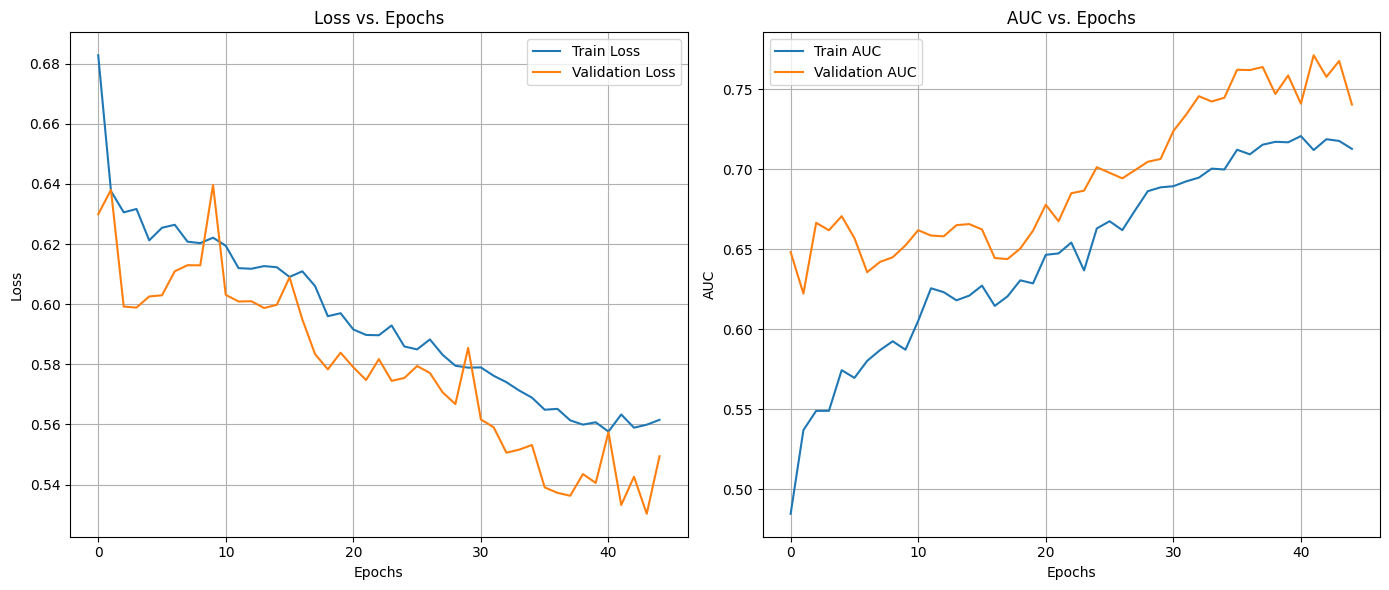

In [13]:
# ==============================================================================
# 5. Logging and Visualization of Results
# ==============================================================================
plt.figure(figsize=(14, 6))
# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
# Plot AUC
plt.subplot(1, 2, 2)
plt.plot(history['train_auc'], label='Train AUC')
plt.plot(history['val_auc'], label='Validation AUC')
plt.title('AUC vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [16]:
# ==============================================================================
# 7. Testing the Model on Unseen Data (with Sensitivity)
# ==============================================================================

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

# 7.1. Load Test Metadata
mass_test_df = pd.read_csv(os.path.join(config.CSV_PATH, 'mass_case_description_test_set.csv'))
calc_test_df = pd.read_csv(os.path.join(config.CSV_PATH, 'calc_case_description_test_set.csv'))
test_df = pd.concat([mass_test_df, calc_test_df], ignore_index=True)

# --- Apply SAME preprocessing pipeline as training/validation ---

def extract_simple_patient_id(pid):
    parts = pid.split('_')
    for i, part in enumerate(parts):
        if part == 'P':
            return f"{part}_{parts[i+1]}"
    return pid

test_df['simple_patient_id'] = test_df['patient_id'].apply(extract_simple_patient_id)
test_df['patient_breast_id'] = test_df['simple_patient_id'] + '_' + test_df['left or right breast']
test_df['label'] = test_df['pathology'].apply(lambda x: 1 if 'MALIGNANT' in x.upper() else 0)

# Map CSV paths to actual JPEGs
test_df['jpeg_path'] = find_jpeg_path(test_df['image file path'])

# Drop missing
original_rows = len(test_df)
test_df.dropna(subset=['jpeg_path'], inplace=True)
print(f"\nSuccessfully mapped {len(test_df)} of {original_rows} test CSV entries to JPEG files.")

# Pair CC/MLO views
paired_test_data = []
grouped = test_df.groupby('patient_breast_id')

for name, group in tqdm(grouped, desc="Pairing CC and MLO views (Test)"):
    cc_view = group[group['image view'] == 'CC']
    mlo_view = group[group['image view'] == 'MLO']

    if not cc_view.empty and not mlo_view.empty:
        for _, cc_row in cc_view.iterrows():
            for _, mlo_row in mlo_view.iterrows():
                paired_test_data.append({
                    'patient_breast_id': name,
                    'cc_path': cc_row['jpeg_path'],
                    'mlo_path': mlo_row['jpeg_path'],
                    'label': cc_row['label']
                })

paired_test_df = pd.DataFrame(paired_test_data)
print(f"\nSuccessfully created {len(paired_test_df)} CC/MLO pairs for Test set.")

# 7.2. Define Test Dataset & Loader
test_dataset = CBISDDSMDataset(paired_test_df, transform=val_transform)  # no augmentations
test_loader = DataLoader(
    test_dataset, batch_size=config.BATCH_SIZE, shuffle=False,
    num_workers=config.NUM_WORKERS, pin_memory=config.PIN_MEMORY
)

# 7.3. Load Best Model
model.load_state_dict(torch.load('mv_swin_t_best_model.pth', map_location=config.DEVICE))
model.to(config.DEVICE)
model.eval()

# 7.4. Evaluate on Test Set
all_preds, all_labels = [], []
test_loss = 0.0

with torch.inference_mode():  
    for batch in tqdm(test_loader, desc="Testing"):
        cc_view, mlo_view, labels = batch['cc_view'].to(config.DEVICE), batch['mlo_view'].to(config.DEVICE), batch['label'].to(config.DEVICE)
        outputs = model(cc_view, mlo_view)
        loss = loss_fn(outputs, labels)
        test_loss += loss.item()
        all_preds.append(torch.sigmoid(outputs).cpu())
        all_labels.append(labels.cpu())

# 7.5. Compute Metrics
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

binary_preds = (all_preds > 0.5).astype(int)

test_loss /= len(test_loader)
test_auc = roc_auc_score(all_labels, all_preds)
test_acc = accuracy_score(all_labels, binary_preds)

tn, fp, fn, tp = confusion_matrix(all_labels, binary_preds).ravel()
sensitivity = tp / (tp + fn + 1e-8)

print(f"\n✅ Test Loss: {test_loss:.4f}")
print(f"✅ Test AUC: {test_auc:.4f}")
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Sensitivity (Recall): {sensitivity:.4f}")


Mapping CSV to JPEG paths:   0%|          | 0/704 [00:00<?, ?it/s]

Mapping CSV to JPEG paths: 100%|██████████| 704/704 [00:00<00:00, 7135.20it/s]



Successfully mapped 704 of 704 test CSV entries to JPEG files.


Pairing CC and MLO views (Test): 100%|██████████| 369/369 [00:00<00:00, 1885.74it/s]



Successfully created 361 CC/MLO pairs for Test set.


Testing: 100%|██████████| 91/91 [02:08<00:00,  1.41s/it]


✅ Test Loss: 0.6777
✅ Test AUC: 0.5860
✅ Test Accuracy: 0.5900
✅ Test Sensitivity (Recall): 0.3308


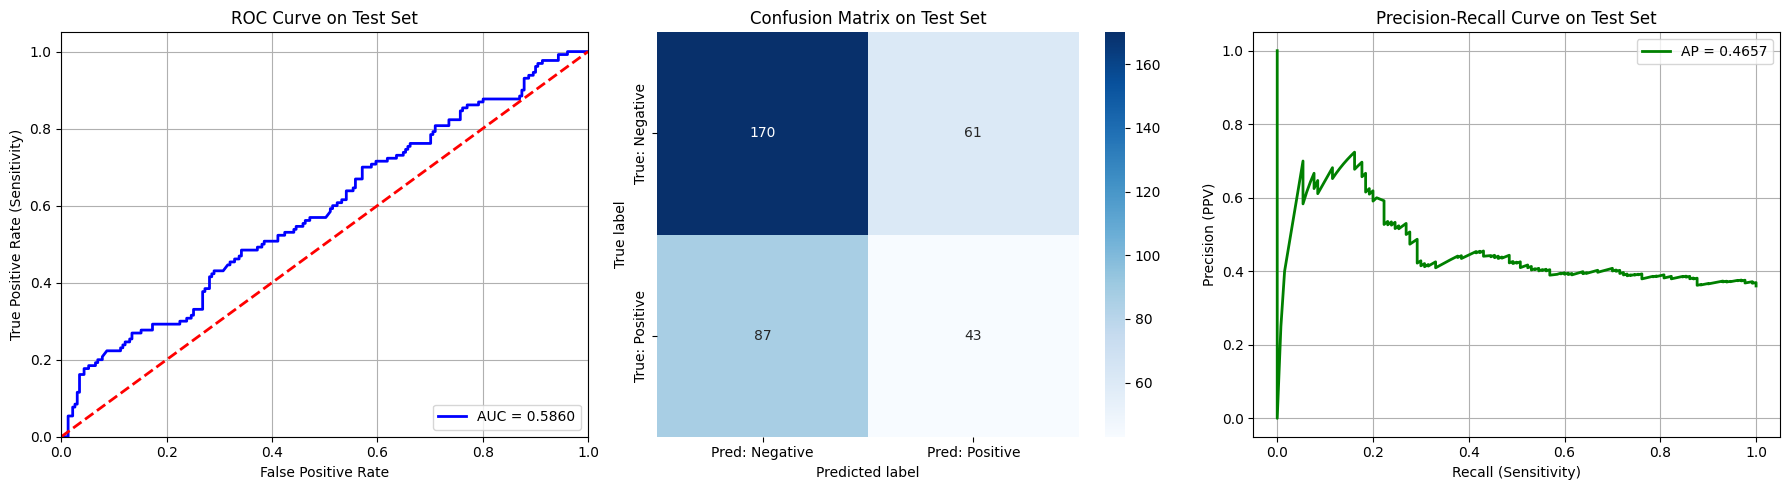

In [17]:
# ==============================================================================
# 8. Graphical Representation of Test Results
# ==============================================================================

from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- ROC Curve values ---
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

# --- Precision-Recall values ---
precision, recall, pr_thresholds = precision_recall_curve(all_labels, all_preds)
ap_score = average_precision_score(all_labels, all_preds)

plt.figure(figsize=(18, 5))

# --- ROC Curve ---
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], color="red", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve on Test Set")
plt.legend(loc="lower right")
plt.grid(True)

# --- Confusion Matrix ---
plt.subplot(1, 3, 2)
cm = confusion_matrix(all_labels, binary_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred: Negative", "Pred: Positive"],
            yticklabels=["True: Negative", "True: Positive"])
plt.title("Confusion Matrix on Test Set")
plt.ylabel("True label")
plt.xlabel("Predicted label")

# --- Precision-Recall Curve ---
plt.subplot(1, 3, 3)
plt.plot(recall, precision, color="green", lw=2, label=f"AP = {ap_score:.4f}")
plt.xlabel("Recall (Sensitivity)")
plt.ylabel("Precision (PPV)")
plt.title("Precision-Recall Curve on Test Set")
plt.legend(loc="upper right")
plt.grid(True)

plt.tight_layout()
plt.show()


In [18]:
# ==============================================================================
# 9. Saving Model Weights aswell as Model Architecture+Weight
# ==============================================================================
# Save both
# Save model weights only
torch.save(model.state_dict(), "breast_cancer_model(base)_weights.pth")
# Later, load weights into the same model architecture
#model = YourModelClass()   # Replace with your CNN+MV SwinTransformer class
#model.load_state_dict(torch.load("breast_cancer_model_weights.pth"))
#model.to(device)
#model.eval()

# Save the entire model
torch.save(model, "breast_cancer_model(base)_full.pth")
# Load entire model
#model = torch.load("breast_cancer_model_full.pth")
#model.to(device)
#model.eval()

In [19]:
# ======================================================================
# 10. GRAD/CAM (Updated)
# ======================================================================
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2

# ------------------ Grad-CAM Helper ------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, cc_tensor, mlo_tensor, target_class=0):
        """
        cc_tensor, mlo_tensor: shape (B, C, H, W)
        target_class: int (0 or 1 for binary classification)
        returns: CAM of shape (H, W)
        """
        self.model.eval()
        cc_tensor = cc_tensor.to(config.DEVICE)
        mlo_tensor = mlo_tensor.to(config.DEVICE)

        output = self.model(cc_tensor, mlo_tensor)

        # Pick scalar for backward
        output_scalar = output[:, target_class].sum()
        self.model.zero_grad()
        output_scalar.backward(retain_graph=True)

        # Grad-CAM computation
        # 1. Global average pooling over HxW
        weights = self.gradients.mean(dim=(2,3), keepdim=True)  # (B, C, 1, 1)

        # 2. Weighted sum of activations
        cam = (weights * self.activations).sum(dim=1)           # (B, H, W)

        # 3. ReLU and convert to numpy
        cam = F.relu(cam)
        cam = cam[0].cpu().numpy()                               # select first sample

        # 4. Resize to original image size
        cam = cv2.resize(cam, (config.IMG_SIZE, config.IMG_SIZE))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)  # normalize to [0,1]

        return cam


# ------------------ Hook Layers ------------------
target_layer_cc = model.cnn_frontend_cc.conv3
target_layer_mlo = model.cnn_frontend_mlo.conv3

gradcam_cc = GradCAM(model, target_layer_cc)
gradcam_mlo = GradCAM(model, target_layer_mlo)

# ------------------ Select One Test Sample ------------------
sample = next(iter(test_loader))
cc_view = sample['cc_view']  # (B, C, H, W)
mlo_view = sample['mlo_view']

# ------------------ Generate CAMs ------------------
cam_cc = gradcam_cc.generate_cam(cc_view, mlo_view)
cam_mlo = gradcam_mlo.generate_cam(cc_view, mlo_view)

# ------------------ Visualize CC View ------------------
plt.figure(figsize=(6,6))
plt.imshow(cc_view[3].permute(1,2,0).cpu().numpy(), cmap='gray')
plt.imshow(cam_cc, cmap='jet', alpha=0.5)
plt.title("Grad-CAM Heatmap (CC View)")
plt.axis('off')
plt.show()

# ------------------ Visualize MLO View ------------------
plt.figure(figsize=(6,6))
plt.imshow(mlo_view[3].permute(1,2,0).cpu().numpy(), cmap='gray')
plt.imshow(cam_mlo, cmap='jet', alpha=0.5)
plt.title("Grad-CAM Heatmap (MLO View)")
plt.axis('off')
plt.show()

AttributeError: 'MVSwinT' object has no attribute 'cnn_frontend_cc'